<a href="https://colab.research.google.com/github/zenafey/colab-notebooks/blob/main/stable-diffusion-civitai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch diffusers requests transformers omegaconf scipy beautifulsoup4 ftfy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 16.4 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=8672fe9947cb864f6bfe1d45dc4aa0b70d16ab24820f2424343437bb5a66f873
  Stored in directory: /root/.cache/pip/wheels/12/

In [16]:
from pathlib import Path
from typing import List

import torch
import requests
import json
import transformers
import os, shutil
from diffusers import StableDiffusionPipeline
from tqdm import tqdm

PROMPT = 'best quality, ultra high res, 1girl, sleeveless white button shirt, black skirt, black choker, cute, (Kpop idol), (aegyo sal:1), (platinum blonde hair:1), ((puffy eyes)), looking at viewer, full body, facing front, (high five: 2), hands'
class test_json:
		guidance_scale = 10.0
		height = 768
		loras = [None]
		model_link = 'https://civitai.com/api/download/models/100675?type=Model&format=SafeTensor&size=pruned&fp=fp16'
		negative_prompt = "worst quality, large head, low quality, extra digits, bad eye, deepnegative, easynegative, bad-hands"
		num_images_per_prompt = 1
		num_inference_steps = 70
		scheduler = 'ddim'
		textual_inversions = [
			{"link": "https://civitai.com/api/download/models/94057?type=Model&format=PickleTensor", "token": "deepnegative"},
			{"link": "https://civitai.com/api/download/models/107234?type=Model&format=SafeTensor", "token": "easynegative"},
			{"link": "https://civitai.com/api/download/models/125849", "token": "bad-hands"}]
		width = 512

In [17]:
class StableDiffusionModel:
    def __init__(self):
        ...

    def download_model(self, link: str, folder='models'):
      resp = requests.get(link, stream=True)
      total = int(resp.headers.get('content-length', 0))
      filename = resp.headers.get('Content-Disposition').split('filename=')[1].strip('"')

      model_path = Path(f"/{folder}/{filename}")
      model_path.parent.mkdir(parents=True, exist_ok=True)
      model_path = str(model_path)

      with open(model_path, 'wb') as file, tqdm(
          desc=model_path,
          total=total,
          unit='iB',
          unit_scale=True,
          unit_divisor=1024,
      ) as bar:
          for data in resp.iter_content(chunk_size=1024):
              size = file.write(data)
              bar.update(size)

      with open('./config.json', 'r+') as f:
                data = json.load(f)
                data[link] = model_path
                f.seek(0)
                json.dump(data, f, indent=4)
                f.truncate()

      return model_path

    def predict(self, prompt: str, kwargs) -> List:

        if not os.path.exists('./config.json'):
            try:
                with open('./config.json', 'w') as f:
                    json.dump({}, f)
            except Exception as e:
                print(e)

        try:
            with open('./config.json', 'r+') as f:
                data = json.load(f)
        except Exception as e:
            print(f"first\n{e}")
            data = {}

        if kwargs.model_link in data:
            model_path = data[kwargs.model_link]
        else:
            model_path = self.download_model(kwargs.model_link)

        pipe = StableDiffusionPipeline.from_single_file(
            model_path,
            torch_dtype=torch.float16
        )
        pipe.safety_checker = lambda images, **kwargs: (images, [False] * len(images))

        pipe.to("cuda")

        for textual_inversion in kwargs.textual_inversions:
            if textual_inversion is None:
                break

            if textual_inversion['link'] in data:
              textual_inversion_path = data[textual_inversion['link']]
            else:
              textual_inversion_path = self.download_model(
                  textual_inversion['link'],
                  'textual_inversions'
              )

            pipe.load_textual_inversion(textual_inversion_path, token=textual_inversion['token'])

        for lora in kwargs.loras:
            if lora is None:
                break

            lora_path = self.download_model(
                lora['link'],
                'loras'
            )

            pipe.load_lora_weights(lora_path)

        images = pipe(
            prompt,
            negative_prompt=kwargs.negative_prompt,
            num_inference_steps=kwargs.num_inference_steps,
            width=kwargs.width,
            height=kwargs.height,
            guidance_scale=kwargs.guidance_scale,
            num_images_per_prompt=kwargs.num_images_per_prompt
            ).images

        output_images = []
        for i, image in enumerate(images):
            path = Path(f"/tmp/sd/image-{i}.jpg")
            path.parent.mkdir(parents=True, exist_ok=True)
            image.save(str(path))
            output_images.append(image)

        return output_images


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/70 [00:00<?, ?it/s]

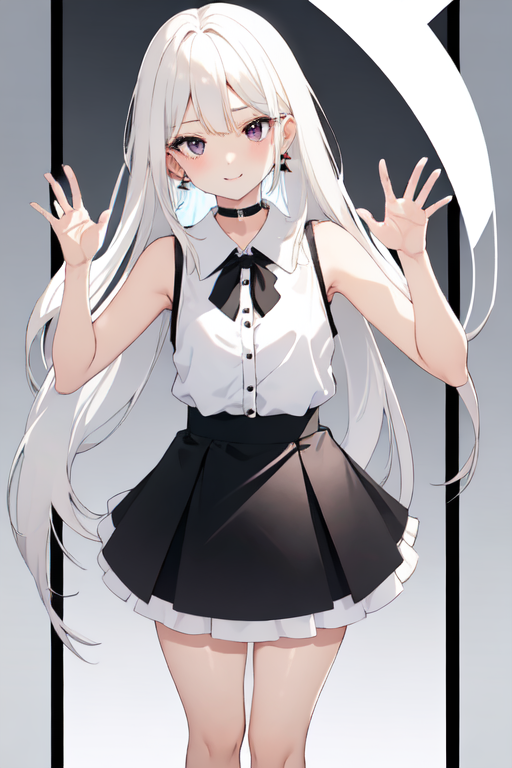

In [19]:
model = StableDiffusionModel()

output = model.predict(PROMPT, test_json)

display(output[0])